# Rigorous enclosures of ODEs 

Consider the ODE

$$ \dot{y} = f(y) = y^2$$

In [1]:
using ValidatedNumerics

INFO: Recompiling stale cache file /Users/dsanders/.julia/lib/v0.4/ValidatedNumerics.ji for module ValidatedNumerics.


In [45]:
f(y) = y^2

f (generic function with 1 method)

Initial condition $y(t=0) = y_0$:

In [46]:
y0 = @interval(1)

[1.0, 1.0]

Fix an interval $[A]$ containing $y_0$. We will think of flowing for a time $h$ such that $y(h)$ is guaranteed to remain inside the box $A$.

In [70]:
A = 0.5..10
y0 ⊆ A

true

Suppose we are able to bound $\dot{y}$ for all times $t \in [0,h]$ such that $m \le \dot{y}(t) \le M$. Then we have

$$y_0 + m \, h \le y(t) \le y_0 + M \, h$$

for all $t \in [0,h]$.

In terms of intervals, if $\dot{y} \in [B]:=[m,M]$ then $y(t) \in y_0 + h[B]$

Since $\dot{y}(t) = f(y(t))$, we can obtain such a bound using interval arithmetic: if $y(t)$ is guaranteed to remain inside $A$, then $\dot{y}(t) \in F([A])$, where $F$ is an interval extension of $F$.

So take $[B] := F([A])$ and then fix $h$ such that $y_0 + h F([A]) \subseteq [A]$:

In [71]:
h = @interval(1)  # initial guess for $h$

y0 + h*f(A)

[1.2499999999999998, 101.00000000000001]

In [72]:
y0 + h*f(A) ⊆ A

false

Reduce $h$ until the inclusion is satisfied:

In [73]:
while !(y0 + h*f(A) ⊆ A)
    h /= 2
end

In [74]:
h

[0.0625, 0.0625]

We now have a guaranteed inclusion for $\tilde{A}(t)$ for $y(t)$, for all $t \in [0,h]$:

In [75]:
Ã(t) = y0 + t*f(A)  # solution y(t) at *any* time t ∈ [0,h] is guaranteed to be inside this set? NO

Ã (generic function with 1 method)

In [76]:
Ã(h)

[1.0156249999999998, 7.250000000000001]

Note that $F([A])$ gives an estimation of the Lipschitz constant of the function $y$ over the set $[A]$.

Note that $\tilde{A}(t)$ gives a cone as a function of $t$ that is always increasing. Thus the set of values of $y$ covered in the evolution until time $t$ is the hull $H_1 := y_0 \sqcup \tilde{A}(h)$:

In [77]:
H = y0 ⊔ Ã(h)

[1.0, 7.250000000000001]

An alternative point of view is to think of this as $y_0 + [0,h] \times f(A)$, which gives the same result:

In [78]:
y0 + (0..h)*f(A)

[1.0, 7.250000000000001]

So we have the inclusion
$y(t) \in H_1$ for all $t \in [0,h]$. We can now use this to reduce the estimation of the range of values of $y$ covered, to get a better Lipschitz constant:

In [79]:
H = y0 + (0..h)*f(H)

[1.0, 4.285156250000001]

And we can repeat:

In [80]:
while true

    H_new = y0 + (0..h)*f(H)
    
    if dist(H_new, H) < 1e-10
        break
    end

    H = H_new
end
H

[1.0, 1.0717967697850093]

This gives us the best enclosure possible for $y(h)$ with this method for the given step size $h$.

We can now continue with more steps:

In [81]:
A = 0.5..1000

y0 = @interval(1)
y = y0

h = 1
t = 0.0

while !(y + h*f(A) ⊆ A)
    h /= 2
end 
h /= 2

ts = Float64[0.0]
enclosures = Interval{Float64}[y0]

while t < 0.8
    
    while !(y + h*f(A) ⊆ A)
        h /= 2
    end 
    
    H = y + h*f(A)

    while true

        H_new = y + h*f(y ⊔ H)

        if dist(H_new, H) < 1e-10
            break
        end

        H = H_new
    end
    
    t += h
    # println("t=$t; h=$h;; enclosure=$H")
    
    y = H
    
    push!(ts, t)
    push!(enclosures, H)
    
end
;
    

In [61]:
length(enclosures)

1640

In [13]:
using PyPlot

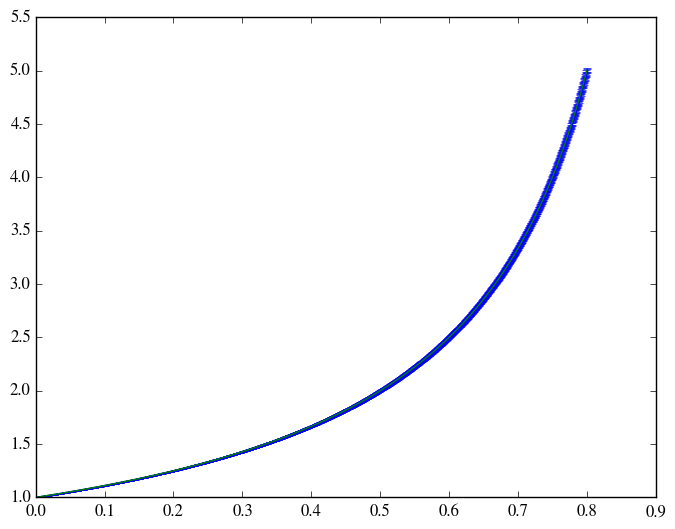

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x326051890>

In [68]:
exact(t) = 1/(1-t)

midpoints = map(mid, enclosures)
radii = map(diam, enclosures) / 2

# for (t, enclosure) in zip(ts, enclosures)
#     plot([t,t], [enclosure.lo, enclosure.hi], "b-")
# end

errorbar(ts, midpoints, radii)

plot(ts, map(exact, ts), "g-")

In [19]:
h

0.00048828125

In [35]:
f(x) = -x

A = -10..10

y0 = @interval(1)
y = y0

h = 1
t = 0.0

while !(y + h*f(A) ⊆ A)
    h /= 2
end 
h /= 2^10

ts = Float64[0.0]
enclosures = Interval{Float64}[y0]

while t < 7
    
    while !(y + h*f(A) ⊆ A)
        h /= 2
    end 
    
    H = y + h*f(A)

    while true

        H_new = y + h*f(y ⊔ H)

        if dist(H_new, H) < 1e-10
            break
        end

        H = H_new
    end
    
    t += h
    #println("t=$t; h=$h; enclosure=$H")
    
    y = H
    
    push!(ts, t)
    push!(enclosures, H)
    
end
    

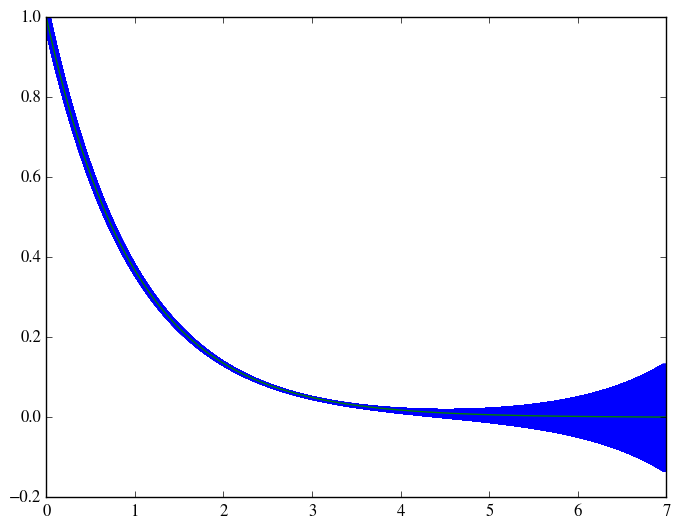

1-element Array{Any,1}:
 PyObject <matplotlib.lines.Line2D object at 0x324b2aa10>

In [36]:
exact(t) = exp(-t)

midpoints = map(mid, enclosures)
radii = map(diam, enclosures) / 2

# for (t, enclosure) in zip(ts, enclosures)
#     plot([t,t], [enclosure.lo, enclosure.hi], "b-")
# end

errorbar(ts, midpoints, radii)

plot(ts, map(exact, ts), "g-")

In [38]:
map(diam, enclosures)

14337-element Array{Float64,1}:
 0.0       
 2.38419e-7
 4.76837e-7
 7.15256e-7
 9.53675e-7
 1.19209e-6
 1.43051e-6
 1.66893e-6
 1.90735e-6
 2.14577e-6
 2.3842e-6 
 2.62262e-6
 2.86104e-6
 ⋮         
 0.266428  
 0.266558  
 0.266688  
 0.266819  
 0.266949  
 0.267079  
 0.26721   
 0.26734   
 0.267471  
 0.267602  
 0.267732  
 0.267863  